1，首先想到利用统计套利，可能会想到两只股票的相关系数是否会让两只股票的走势有一种特定关系。


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

首先相关系数的公式定义为下，将协方差标准化即得到我们需要的相关系数
$$\frac{Cov(X, Y)}{std(X)std(Y)}$$

$$= \frac{Cov(X, Y)}{\sqrt{var(X)}\sqrt{var(Y)}}$$

$$= \frac{Cov(X, Y)}{\sqrt{Cov(X, X)}\sqrt{Cov(Y, Y)}}$$我们来看看相关系数高的数据集具体长什么样

相关系数：0.938486943102


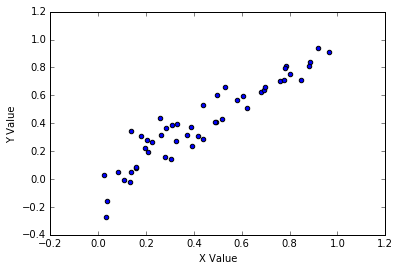

In [3]:
X = np.random.rand(50)
Y = X + np.random.normal(0, 0.1, 50)

plt.scatter(X,Y)
plt.xlabel('X Value')
plt.ylabel('Y Value')

print ('相关系数：' + str(np.corrcoef(X, Y)[0, 1]))

从图像上看，数据基本都落在一条直线上那么它们之间的相关性就会很高。
接下来我们来看看两只股票价格之间相关性高长什么样

601618.XSHG与600026.XSHG之间的相关系数:  0.968302764073


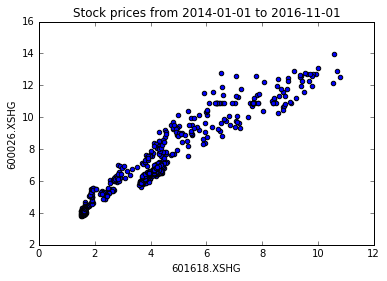

In [4]:
start = '2014-01-01'#此处时间一定要与回测的时间相对应，因为不同时间可能相关性不一致
end = '2016-11-01'
stock1='601618.XSHG'
stock2='600026.XSHG'
a1 = get_price(stock1,fields='ClosingPx', start_date=start, end_date=end)
a2 = get_price(stock2,fields='ClosingPx', start_date=start, end_date=end)
#上图
plt.scatter(a1,a2)
plt.xlabel(stock1)
plt.ylabel(stock2)
plt.title('Stock prices from ' + start + ' to ' + end)
print (stock1+"与"+stock2+"之间的相关系数: ", np.corrcoef(a1,a2)[0,1])

同样数据大多都集中在一条直线上

找到相关性高的股票对，我们要来研究它们之间的价差，因为这是我们策略套利的关键

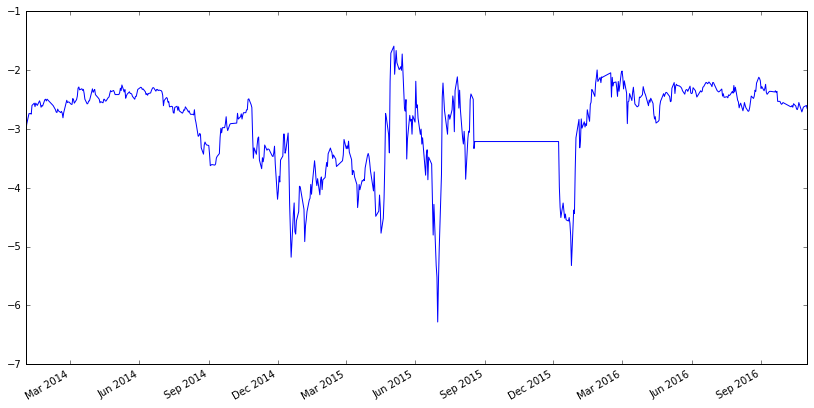

In [5]:
a3=a1-a2
a3.plot(figsize=(14,7))

从图中看出，所以相关系数高，两者之间的价差不一定会围绕一个常数波动，价差会具有一定的变异性，即价差序列是非平稳的。
我们来检验下价差的平稳性。

In [6]:
from statsmodels.tsa.stattools import adfuller
adftest = adfuller(a3)#使用adf单位根检验平稳性
result = pd.Series(adftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
for key,value in adftest[4].items():
        result['Critical Value (%s)'%key] = value
print(result)

Test Statistic                  -3.603560
p-value                          0.005693
Lags Used                        8.000000
Number of Observations Used    681.000000
Critical Value (5%)             -2.865793
Critical Value (1%)             -3.439989
Critical Value (10%)            -2.569035
dtype: float64


上面使用了adf单位根检验，具体的我们会在下一部分协整套利部分来具体讲解，此处检验出来价差非平稳，套利策略的数据基础不好。

进一步的我们来看看以均值加减一倍标准差是否包含了大部分的差价区间

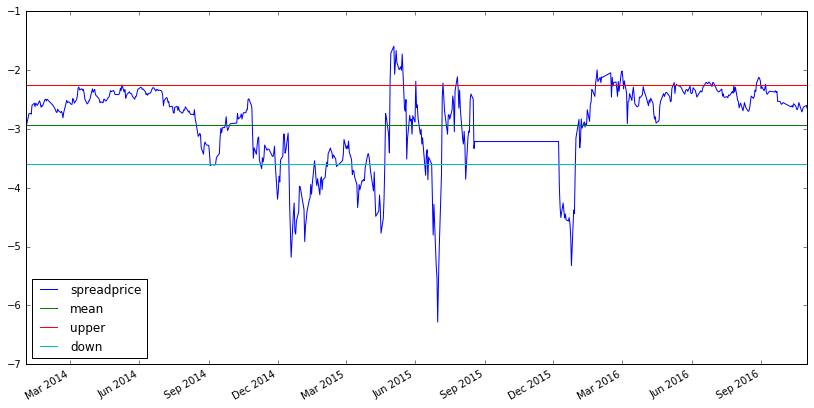

In [7]:
mean=np.mean(a3)
std=np.std(a3)
up=mean+std
down=mean-std
time=a3.index
mean_line=pd.Series(mean,index=time)
up_line=pd.Series(up,index=time)
down_line=pd.Series(down,index=time)
set=pd.concat([a3,mean_line,up_line,down_line],axis=1)
set.columns=['spreadprice','mean','upper','down']
set.plot(figsize=(14,7))

可以看到虽然包含了大部分价差区间，但是开仓次数太少，并且在2014年股票的差价都是在上开仓线附近小幅波动，会造成频繁开仓使得成本十分高。
同时观察2015年价差出现极端值，此时如果开仓，价差不收敛，如果没做到好的平仓条件此时会造成大量亏损。
尽管看图像上通过相关系数来做配对交易不太理想，我们还是通过回测来看看具体结果。

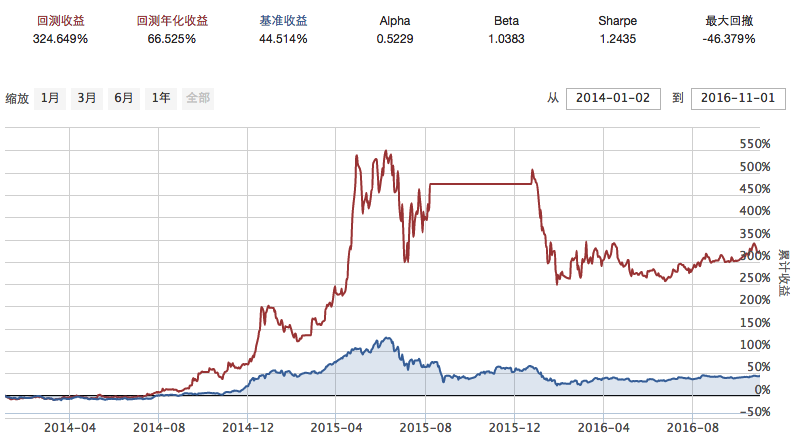

但是因为中国市场上无法做空，但配对交易需要运用卖空来构建对冲仓位，我们试试在允许做空的情况下策略表现会不会相对较好一点

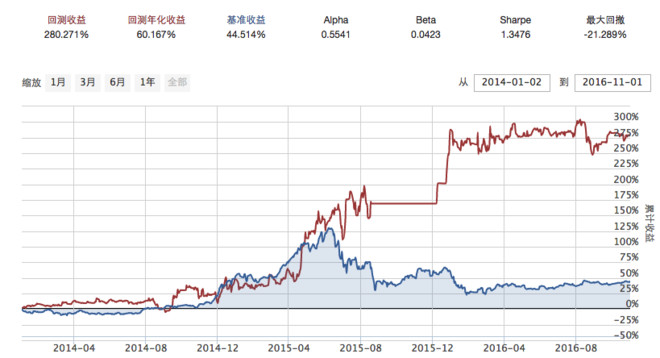

从回测结果对比来看可卖空时收益曲线相对平滑点，最大回测也相对较小，其中亏损来源于价差无法收敛，所以最大回撤在于价差在极端值时出现，这就是价差非平稳时进行套利的弊端，当数据集是平稳序列时此会改善很多。

中国中冶和中海发展在2014-1-1和2016-11-1的相关性是0.968.让我们计算其60日滚动相关性来看看两者如何变化。

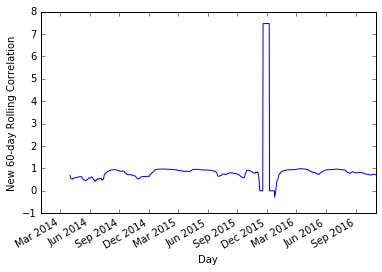

In [8]:
rolling_correlation_cn = pd.rolling_corr(a1, a2, 60)
rolling_correlation_cn.plot()
plt.xlabel('Day')
plt.ylabel('New 60-day Rolling Correlation')

从相关系数的60日滚动相关性来看其实这两只股票相关性高是因为他们在2015年一段时间同时停牌，造成这段时间的相关系数为1，从而拉高了整个时间段内的相关系数，不过两只股票同时停牌也能说明一定问题，比如他们可能会有重组的可能，当然这是后话了。
不过选择股票对时应尽量选取没有停牌的股票。

以一个协整关系比较好的股票对601169与601328来作为对照，看看它们之间的差价变动情况。

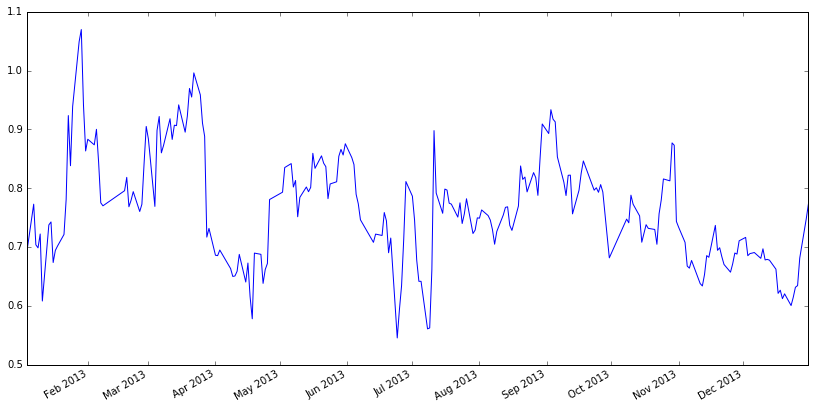

In [9]:
begindate="2013-01-01"
endDate="2014-01-01"
data1=get_price('601169.XSHG', start_date=begindate, end_date=endDate,fields='ClosingPx')
data2=get_price('601328.XSHG', start_date=begindate, end_date=endDate,fields='ClosingPx')
diff=data1-data2
diff.plot(figsize=(14,7))

这两只股票满足协整性，作为配对交易的股票对比较适合，接下来下一部分我们就会谈到利用协整关系来套利